In [1]:
import sys
import os
import random
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import numpy as np
from numpy import cos, sin
import astropy.coordinates as coord
import astropy.units as u
from math import *
from time import time
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from itertools import chain
from astropy import coordinates as coord
from astropy import units as unit

In [2]:
# **************************************
# returns radian
def SGxy(l, b, Vls):
   
    H0 = 1.
    cl = np.cos(l*pi/180.)
    sl = np.sin(l*pi/180.)
    cb = np.cos(b*pi/180.)
    sb = np.sin(b*pi/180.)
   
    x = cl * cb
    y = sl * cb
    z = sb
   
    SGX = x*Vls/H0
    SGY = y*Vls/H0
    SGZ = z*Vls/H0
   
    return SGX, SGY, SGZ
 
# **************************************
# Vls[i] = Vh2Vls(gl[i], gb[i], Vhel3[i])
def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    
    return vls
################################################################# 
### (another "Vlg" has been given by Courteau and van den Bergh; another by Yahil et al.)
### The Vlg used in MKgroups is their own version. 
### The following function just works fine for MK-groups
def Vlg2Vh(el,b, Vlg):
  
    alpha = pi / 180.
    
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    

    Vh=float(Vlg)+16.*cosl*cosb-315.*sinl*cosb+22.*sinb
    #vls = float(Vh)-26.*cosl*cosb+317.*sinl*cosb-8.*sinb
    
    
    return Vh


In [3]:

TMRS = np.genfromtxt('../2MRS.csv' , delimiter=',', filling_values="-100000", names=True, dtype=None )

TMRS_pgc = TMRS['PGC']  # 2MRS
TMRS_sgl = TMRS['SGL']
TMRS_sgb = TMRS['SGB']
TMRS_gl = TMRS['Glon']
TMRS_gb = TMRS['Glat']
TMRS_vh = TMRS['Vhel']

CF3 = np.genfromtxt('../CF3.csv' , delimiter=',', filling_values="-100000", names=True, dtype=None )
CF3_pgc = CF3['PGC']  # CF2D
CF3_sgl = CF3['SGL']
CF3_sgb = CF3['SGB']
CF3_gl  = CF3['Glon']
CF3_gb  = CF3['Glat']
CF3_vls = CF3['Vls']


table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
CF4_pgc = table['pgc'] 


inFile  = '../EDD_distance_cf4_v27.csv'
table   = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)
cf4_pgc = table['pgc']
cf4_sgl = table['sgl']
cf4_sgb = table['sgb']
cf4_vls  = table['Vls']


Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [4]:
_, _, indx = np.intersect1d(CF4_pgc, cf4_pgc, return_indices=True)

cf4_pgc  = cf4_pgc[indx]
cf4_sgl  = cf4_sgl[indx]
cf4_sgb  = cf4_sgb[indx]
cf4_vls  = cf4_vls[indx]

cf4_sgx, cf4_sgy, cf4_sgz = SGxy(cf4_sgl, cf4_sgb, cf4_vls)

cf3_sgx, cf3_sgy, cf3_sgz = SGxy(CF3_sgl, CF3_sgb, CF3_vls)
ibx = np.logical_not(np.isin(CF3_pgc, cf4_pgc))
cf3_sgx = cf3_sgx[ibx]
cf3_sgy = cf3_sgy[ibx]
cf3_sgz = cf3_sgz[ibx]


TMRS_vls = Vh2Vls(TMRS_gl, TMRS_gb, TMRS_vh)
tmrs_sgx, tmrs_sgy, tmrs_sgz = SGxy(TMRS_sgl, TMRS_sgb, TMRS_vls)
ibx = np.logical_not(np.isin(TMRS_pgc, np.concatenate((cf4_pgc, cf3_sgx))))
tmrs_sgx = tmrs_sgx[ibx]
tmrs_sgy = tmrs_sgy[ibx]
tmrs_sgz = tmrs_sgz[ibx]


(array([-20000., -15000., -10000.,  -5000.,      0.,   5000.,  10000.,
         15000.,  20000.]), <a list of 9 Text xticklabel objects>)

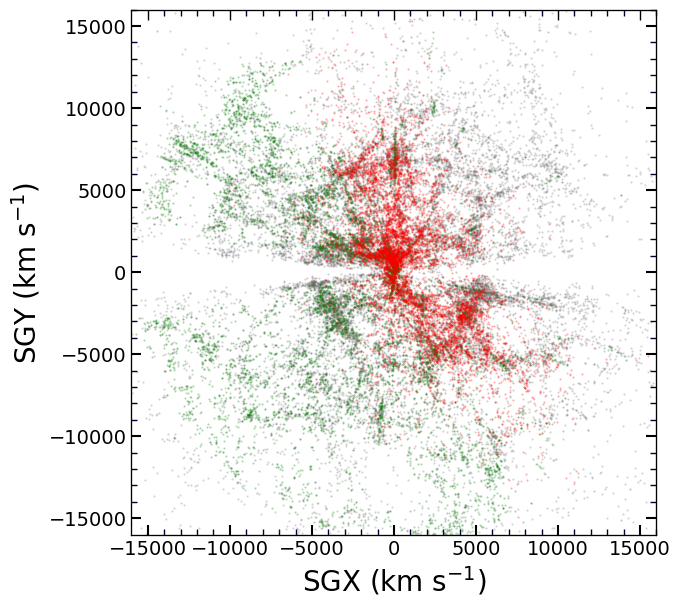

In [5]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=7, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=7, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function


fig = plt.figure(figsize=(7, 7), dpi=100)

ax = fig.add_axes([0.19, 0.19, 0.75,  0.75]) 
ax.xaxis.set_major_locator(MultipleLocator(5000))
ax.yaxis.set_major_locator(MultipleLocator(5000))
#ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(1))  


ax.minorticks_on()
ax.tick_params(which='major', length=7, width=1.5)
ax.tick_params(which='minor', length=4, color='#000033', width=1.0)     


## 2MRS
indx, = np.where(np.abs(tmrs_sgz)<4000)
ax.plot(tmrs_sgx[indx], tmrs_sgy[indx],'.', markersize = 1, color='#696969', alpha=0.3) 


##CF3D - Green
indx, = np.where(np.abs(cf3_sgz)<4000)
ax.plot(cf3_sgx[indx], cf3_sgy[indx], '.', markersize = 1.1, color='green', alpha=0.3) 


##ALFALFA - red
indx, = np.where(np.abs(cf4_sgz)<4000)
ax.plot(cf4_sgx[indx], cf4_sgy[indx], '.', markersize = 1.1, color='red', alpha=0.3) 

limit = 16000

set_axes([ax], (-1.*limit,limit), (-1.*limit,limit))

ax.set_xlabel("SGX (km s"+r"$^{-1}$"+")", fontsize=20)
ax.set_ylabel("SGY (km s"+r"$^{-1}$"+")", fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)




(array([-20000., -15000., -10000.,  -5000.,      0.,   5000.,  10000.,
         15000.,  20000.]), <a list of 9 Text xticklabel objects>)

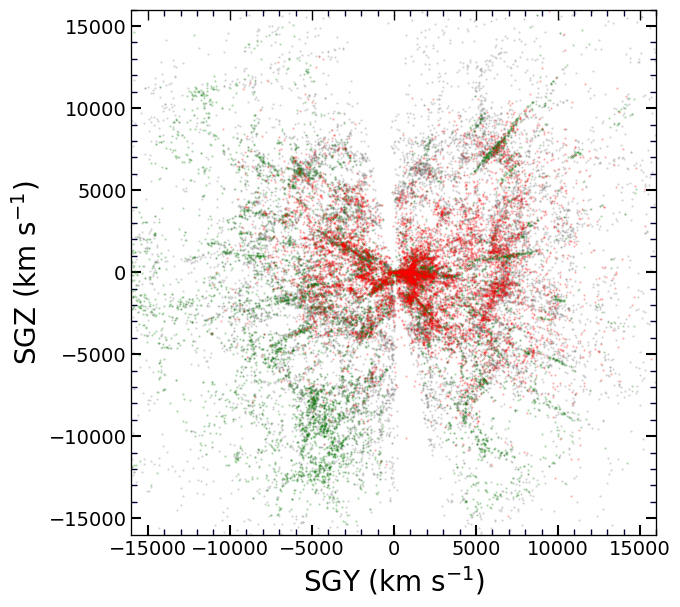

In [6]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=7, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=7, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function


fig = plt.figure(figsize=(7, 7), dpi=100)

ax = fig.add_axes([0.19, 0.19, 0.75,  0.75]) 
ax.xaxis.set_major_locator(MultipleLocator(5000))
ax.yaxis.set_major_locator(MultipleLocator(5000))
#ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(1))  


ax.minorticks_on()
ax.tick_params(which='major', length=7, width=1.5)
ax.tick_params(which='minor', length=4, color='#000033', width=1.0)     


## 2MRS
indx, = np.where(np.abs(tmrs_sgx)<4000)
ax.plot(tmrs_sgy[indx], tmrs_sgz[indx],'.', markersize = 1, color='#696969', alpha=0.3) 


##CF3D - Green
indx, = np.where(np.abs(cf3_sgx)<4000)
ax.plot(cf3_sgy[indx], cf3_sgz[indx], '.', markersize = 1.1, color='green', alpha=0.3) 


##ALFALFA - red
indx, = np.where(np.abs(cf4_sgx)<4000)
ax.plot(cf4_sgy[indx], cf4_sgz[indx], '.', markersize = 1.1, color='red', alpha=0.3) 

limit = 16000

set_axes([ax], (-1.*limit,limit), (-1.*limit,limit))

ax.set_xlabel("SGY (km s"+r"$^{-1}$"+")", fontsize=20)
ax.set_ylabel("SGZ (km s"+r"$^{-1}$"+")", fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)




(array([-20000., -15000., -10000.,  -5000.,      0.,   5000.,  10000.,
         15000.,  20000.]), <a list of 9 Text xticklabel objects>)

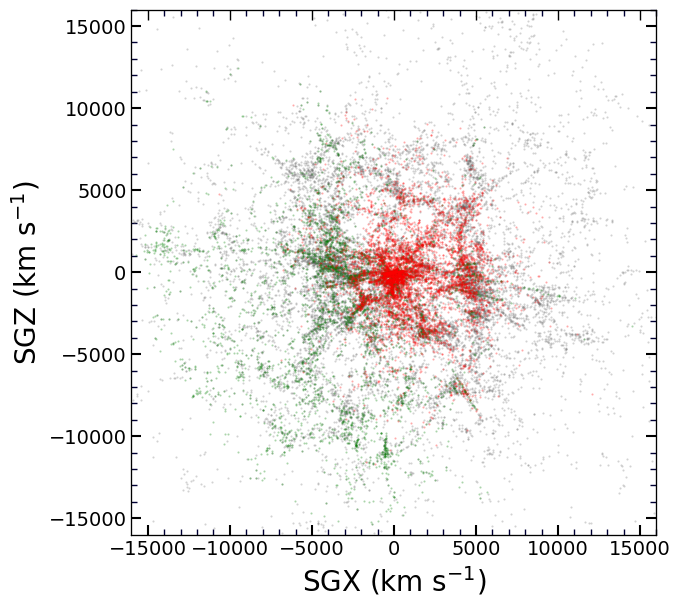

In [7]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=7, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=7, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=7, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function


fig = plt.figure(figsize=(7, 7), dpi=100)

ax = fig.add_axes([0.19, 0.19, 0.75,  0.75]) 
ax.xaxis.set_major_locator(MultipleLocator(5000))
ax.yaxis.set_major_locator(MultipleLocator(5000))
#ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(1))  


ax.minorticks_on()
ax.tick_params(which='major', length=7, width=1.5)
ax.tick_params(which='minor', length=4, color='#000033', width=1.0)     


## 2MRS
indx, = np.where(np.abs(tmrs_sgy)<4000)
ax.plot(tmrs_sgx[indx], tmrs_sgz[indx],'.', markersize = 1, color='#696969', alpha=0.3) 


##CF3D - Green
indx, = np.where(np.abs(cf3_sgy)<4000)
ax.plot(cf3_sgx[indx], cf3_sgz[indx], '.', markersize = 1.1, color='green', alpha=0.3) 


##ALFALFA - red
indx, = np.where(np.abs(cf4_sgy)<4000)
ax.plot(cf4_sgx[indx], cf4_sgz[indx], '.', markersize = 1.1, color='red', alpha=0.3) 

limit = 16000

set_axes([ax], (-1.*limit,limit), (-1.*limit,limit))

ax.set_xlabel("SGX (km s"+r"$^{-1}$"+")", fontsize=20)
ax.set_ylabel("SGZ (km s"+r"$^{-1}$"+")", fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)


